In [1]:
from sklearn import linear_model

import glob
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../../")
from mfilter.types import FrequencySamples, TimeSeries, FrequencySeries, TimesSamples

In [2]:
# functions

# read file
def read_file():
     # folder MLensing with the files should be placed out 
     # of the root file of the project (the one with the .git)
    return glob.glob("../../../MLensing/*.mjd")

# read data
def read_data(files, j, ini, end, normalize_time=False):
    a = pd.read_csv(files[j], skiprows=3, header=None, sep=" ") # read the table
    a.columns = ["MJD", "Mag", "err"] # name the columns
    times = TimesSamples(a["MJD"][ini:end]) # read the times in MJD
    times -= times.min() # normalize to 0, this give us units of days
    times *= days_to_sec # transform to units of seconds
    if normalize_time:
        print("before normalize, we get an average sampling rate of:", 
              times.average_fs, "samples per seconds")
        times *= times.average_fs # normalize to units of samples (for digital signals)
        print("after normalize, we get an average sampling rate of:", times.average_fs, 
              "samples per cycles \n with this, perfect reconstruction is guaranteed " +
              "possible for a bandlimit of: ", times.average_fs/2)
        
    data = TimeSeries(a["Mag"][ini:end], times=times) # get the magnitude
    data -= np.median(data) # normalize the magnitud to 0 (the center goes to 0).
    err =  a["err"].tolist()[ini:end] # get the error
    return times, data, err


In [3]:
reg1 = linear_model.SGDRegressor(alpha=1e-8, max_iter=1000, penalty='l2', l1_ratio=0.5, tol=0.001)
reg2 = linear_model.SGDRegressor(alpha=1e-8, max_iter=1000, penalty='l2', l1_ratio=0.5, tol=0.001)

average nyquist limit of these time samples is:  1.9252012294334093e-06 Hz
0.0 0.34391019753685936 1.3287968554354117


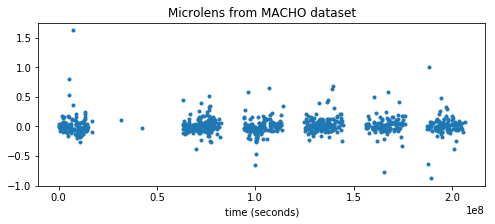

In [4]:
j = 10 # the particular observation to use, j={5, 9, 14} gives bad results 
ini = 0 # init of a range of the observations, we use the whole data
end = -1 # end of a range of the observation, we use the whole data
days_to_sec = 1 * 24 * 60 * 60 # transformation from days to seconds
sec_to_days = 1 /(60 * 60 * 24) # transformation from seconds to days

files = read_file()
times0, data0, err = read_data(files, j, ini, end, normalize_time=False)
# times0 *= sec_to_days
fig = plt.figure(figsize=(8,3))
plt.plot(times0, data0, '.')
plt.title("Microlens from MACHO dataset")
plt.xlabel("time (seconds)")
print("average nyquist limit of these time samples is: ", times0.average_fs/2, "Hz")
# print("with a minimum wavelenth of: ", c*2/times0.average_fs, "meters")
print(times0[0]*times0.average_fs, times0[1]* times0.average_fs, times0[2]* times0.average_fs)
# times /= 

fs: 1.1111111111111112 fs2: 1.0
nyquist limit frequency is:  0.5555555555555556
from these, f1: 0.5555555555555556 and f2: 0.2777777777777778
and their lambas are lambda1: 540000000.0 and lambda2: 1080000000.0


array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

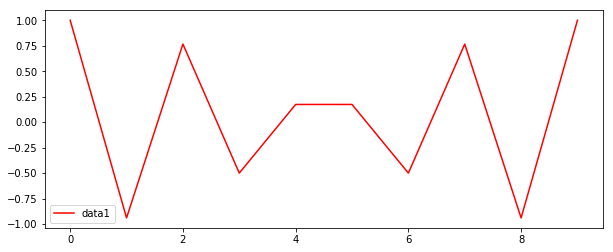

In [81]:
# using simulated signals (sin)

# time
beta = 1
times = TimesSamples(np.linspace(times0.min(), times0.max(), beta*len(times0)))
times = TimesSamples(np.linspace(0, 9, 10))
# times *= sec_to_days
# nyquist limit (maximum recognizable  frequency)
nyq = times.average_fs / 2
print("fs:", times.average_fs, "fs2:", (len(times)-1)/times.duration)
print("nyquist limit frequency is: ", nyq)
# frequencies in Hz, lets declare f1 as 1/10 of nyq and f2 as 1/6 of nyq
f1 = nyq
f2 = nyq/2
print("from these, f1:", f1, "and f2:", f2)
c = 300000000 # light speed in m/s
print("and their lambas are lambda1:", c/f1, "and lambda2:", c/f2)

data1 = TimeSeries(np.cos(2 * np.pi * f1 * times), times=times)
# data2 = TimeSeries(np.sin(2 * np.pi * f1 * times)*0.8 + np.sin(2 * np.pi * f2 * times)*0.2, times=times)
plt.figure(figsize=(10, 4))
plt.plot(times, data1, 'r-', label="data1")
# plt.plot(times, data2, 'b-', label="data2")
plt.legend()
times.value

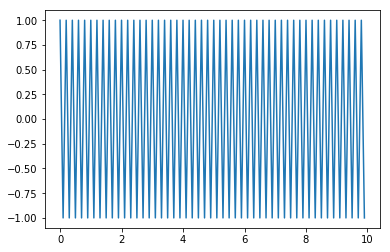

In [86]:
fs = 10
nyq = fs/2
f1 = nyq
times2 = np.arange(100)/fs
data = np.cos(2 *  np.pi * f1 * times2)
plt.plot(times2, data)
# times2

In [158]:
# fourier matrix

#frequencies, using averaged nyquist limit
nyq2 = len(times) / times.duration / 2

minf = 1 / times.duration #min freq, avoid 0
freqs = FrequencySamples(input_time=times, minimum_frequency=minf, maximum_frequency=nyq2, samples_per_peak=1)
freqs = FrequencySamples(initial_array=np.append(np.sort(-freqs.value), freqs.value), df=freqs.basic_df)
# matrix
m = times.value.reshape(-1, 1) * freqs.value
m = np.exp(2j * np.pi * m)
m = np.hstack((m.real, m.imag))


In [159]:
reg1.fit(m, data1)
# save these coefs
coefs1 = np.copy(reg1.coef_)
# clear the coefs in reg1
reg2.coef_ = None
reg1.fit(m, data2)
coefs2 = np.copy(reg1.coef_)

In [160]:
def _cast_into_ft(coefs):
    n_freqs = int(len(coefs) / 2)
    ft = 1j * np.zeros(n_freqs)
    for i in range(n_freqs):
        ft[i] = coefs[i] - 1j * coefs[i + n_freqs]
    return ft

ft1 = _cast_into_ft(coefs1)
ft2 = _cast_into_ft(coefs2)

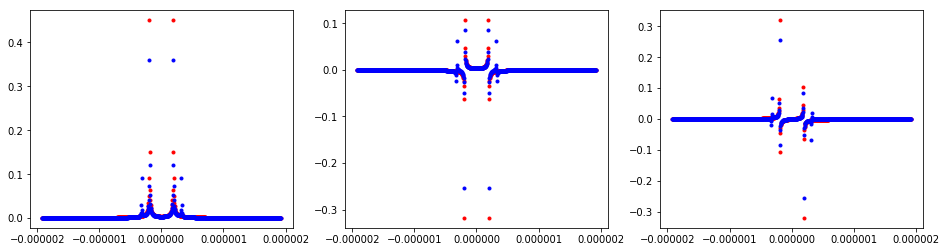

In [161]:

fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(16, 4))
ax1.plot(freqs, np.abs(ft1), 'r.')
ax1.plot(freqs, np.abs(ft2), 'b.')
ax2.plot(freqs, np.real(ft1), 'r.')
ax2.plot(freqs, np.real(ft2), 'b.')
ax3.plot(freqs, np.imag(ft1), 'r.')
ax3.plot(freqs, np.imag(ft2), 'b.')
# plt.fill_between(np.arange(len(coefs2)), coefs1, coefs2)

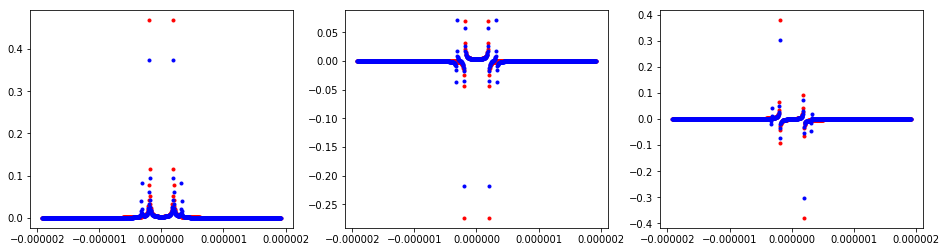

In [162]:
# using fft
fft1 = np.fft.fft(data1)
fft2 = np.fft.fft(data2)
fftfreq = np.fft.fftfreq(len(data1), d=times.duration / len(times))


fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(16, 4))
ax1.plot(fftfreq, np.abs(fft1)/len(times), 'r.')
ax1.plot(fftfreq, np.abs(fft2)/len(times), 'b.')
ax2.plot(fftfreq, np.real(fft1)/len(times), 'r.')
ax2.plot(fftfreq, np.real(fft2)/len(times), 'b.')
ax3.plot(fftfreq, np.imag(fft1)/len(times), 'r.')
ax3.plot(fftfreq, np.imag(fft2)/len(times), 'b.')

In [164]:
# lets check first if this mach, find the peaks frequency,

# find the args where the peak happends
peakft1 = np.argmax(np.abs(ft1))
peakfft1 = np.argmax(np.abs(fft1))
print(freqs[peakft1], np.fft.fftfreq(len(times))[peakfft1], fftfreq[peakfft1])

-1.9373094132663237e-07 0.05031446540880503 1.9373094132663237e-07


In [147]:
np.fft.fftfreq(len(times))[peakfft1] * len(times) / times.duration

1.4529820599497427e-08

In [163]:
f1

1.9252012294334094e-07

In [154]:
times.average_fs / 2

1.9252012294334093e-06

In [129]:
np.argmax(np.abs(ft1))

394

In [136]:
f1 / fftfreq[np.argmax(np.abs(fft1))]

6882.397433280002

NYQUIST ES IMPORTANTE Y PUEDE SER UN FACTOR LIMITANTE, EN SI EL MAYOR FACTOR ES QU IMPONER COMO FREQ MAXIMA NYQUIST PUEDE HACERNOS PERDER TODA LA INFORMACION RELETANTE

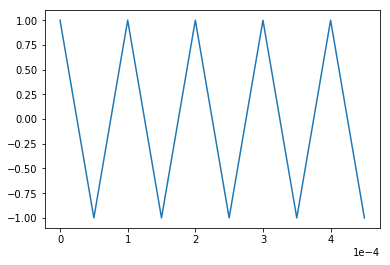

In [58]:
fs = 10000*2
times = np.arange(10) / fs

# times =  np.linspace(0, 6e-4, 1000)
data = np.cos(2 * np.pi * 10000 * times)
plt.plot(times, data, '-')
plt.ticklabel_format(axis='x',style='sci',scilimits=(0,0))

In [49]:
np.arange(4)

array([0, 1, 2, 3])